In [1]:
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from xgboost import XGBRegressor,XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,f1_score,precision_score,recall_score

from sklearnex import patch_sklearn,unpatch_sklearn

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import RFE

from scipy.stats import f_oneway

import gc
import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from Interaction_effect_features import get_data

from MetaHeuristics import FeatureSelection

# from EvolutionaryFS import GeneticAlgorithmFS
# from SimmulatedAnnealingFS import SimulatedAnnealingFS
# from ACO import AntColonyOptimizationFS
# from PSOFinal import ParticleSwarmOptimizationFS

import shap

np.seterr(divide = 'ignore')
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
# suppress warnings
warnings.filterwarnings('ignore')

In [2]:
def make_plot(metric,test_cost,external_cost):
    sns.set(rc={'figure.figsize':(16,8)})
    sns.set_context('paper', font_scale = 1.3)
    if metric=='RMSE':
        fig, ax = plt.subplots(1, 2)
    else:
        fig, ax = plt.subplots(1, 2, sharey=True)
        
    validation_name = [' External_Test','External_Test ',' External_Test ',' External_Test  ','  External_Test']

    ax[0].bar(list(test_cost.keys()),list(test_cost.values()))
    ax[0].set_title(metric + ' for test data and validation data')

    ax[1].bar(validation_name,external_cost)
    ax[1].set_title(metric + ' for external test data')
    plt.show()

def get_data_for_FS(data_dict,dependent_variable,features_all):
    
    data_dict_for_SA = {}
    
    x_validation = data_dict['data_validation_test'][features_all]
    y_validation = data_dict['data_validation_test'][dependent_variable]

    #for each training data
    for data_fold_index in data_dict['fold_dict'].keys():
        
        for feature in features_all:
            if feature not in data_dict['fold_dict'][data_fold_index]['fold_training'].columns:
                print(feature,'not present')

        data_dict_for_SA[data_fold_index]={'x_train':data_dict['fold_dict'][data_fold_index]['fold_training'][features_all],
                                           'y_train':data_dict['fold_dict'][data_fold_index]['fold_training'][dependent_variable],
                                           'x_test':data_dict['fold_dict'][data_fold_index]['fold_test'][features_all],
                                           'y_test':data_dict['fold_dict'][data_fold_index]['fold_test'][dependent_variable]}
    
    
    return data_dict_for_SA,x_validation,y_validation,features_all

def last_preprocessing(data_dict,problem):
    
    #'HotelCancellations', 'CouponRecommendation', 'PredictRoomBooking','CarSales'
    
    if problem == 'PredictRoomBooking':
        columns = ['AdjustedLeadTime_Quartile_countRankEncoded', 'CumulativeNumberOfRooms_Quartile_percentEncoded', 'CumulativeNumberOfRooms_Quartile_countRankEncoded', 'CumulativeNumberOfRooms_Quartile_MeanEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_percentEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_countRankEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_MeanEncoded', 'CumulativeNumberOfRoomsNet_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_percentEncoded', 'CumulativeRevenue_Quartile_countEncoded', 'CumulativeRevenue_Quartile_percentEncoded', 'CumulativeRevenue_Quartile_countRankEncoded', 'CumulativeRevenue_Quartile_MeanEncoded', 'CumulativeRevenueSubstract_Quartile_percentEncoded', 'CumulativeRevenueSubstract_Quartile_countRankEncoded', 'CumulativeRevenueNet_Quartile_percentEncoded', 'CumulativeRevenueNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_MeanEncoded','AdjustedLeadTime_Quartile_percentEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_percentEncoded','AdjustedLeadTime_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_percentEncoded', 'CumulativeRevenueSubstract_Quartile_countEncoded', 'CumulativeRevenueSubstract_Quartile_MeanEncoded', 'CumulativeRevenueNet_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_countEncoded','AdjustedLeadTime_Quartile_MeanEncoded', 'CumulativeNumberOfRooms_Quartile_countEncoded', 'CumulativeRevenueNet_Quartile_countRankEncoded','AdjustedLeadTimeCumulativeRevenue_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_percentEncoded']
    elif problem == 'HotelCancellations':
        columns = ['LeadTime_Quartile_countEncoded','LeadTime_Quartile_percentEncoded','LeadTime_Quartile_countRankEncoded','LeadTime_Quartile_MeanEncoded','ADR_Quartile_countEncoded','ADR_Quartile_percentEncoded','ADR_Quartile_countRankEncoded','ADR_Quartile_MeanEncoded']
    elif problem == 'CouponRecommendation':
        columns = []
    elif problem == 'CarSales':
        columns = ['ownercountEncodedandkmdrivenQuartileMeanEncoded','sellertypecountEncodedandownercountEncoded','fuelcountEncodedandownerMeanEncoded','ownercountEncodedandmaxpowerQuartileMeanEncoded','ownercountEncodedandkmdrivenQuartilecountEncoded','ownercountEncodedandmileageQuartileMeanEncoded','ownercountEncodedandmileageQuartilecountEncoded','fuelcountEncodedandkmdrivenQuartileMeanEncoded','sellertypecountEncodedandmaxpowerQuartileMeanEncoded','fuelcountEncodedandmaxpowerQuartilecountEncoded','ownercountEncodedandmaxpowerQuartilecountEncoded','sellertypecountEncodedandownerMeanEncoded','fuelcountEncodedandkmdrivenQuartilecountEncoded','sellertypecountEncodedandmileageQuartileMeanEncoded','fuelcountEncodedandownercountEncoded','sellertypecountEncodedandmileageQuartilecountEncoded','sellertypecountEncodedandmaxpowerQuartilecountEncoded','fuelcountEncodedandsellertypecountEncoded','fuelcountEncodedandmileageQuartileMeanEncoded','fuelcountEncodedandmileageQuartilecountEncoded','sellertypecountEncodedandkmdrivenQuartileMeanEncoded','sellertypecountEncodedandkmdrivenQuartilecountEncoded','mileageQuartilecountEncodedandmaxpowerQuartilecountEncoded','kmdrivenQuartilecountEncodedandmileageQuartilecountEncoded','kmdrivenQuartilecountEncodedandmaxpowerQuartilecountEncoded','kmdriven_Quartile_percentEncoded','maxpower_Quartile_percentEncoded','mileage_Quartile_percentEncoded']
    
    if columns:
        for feature in columns:
            if feature in data_dict['data_external_test'].columns:
                data_dict['data_external_test'][feature] = data_dict['data_external_test'][feature].astype(int)
                data_dict['data_validation_test'][feature] = data_dict['data_validation_test'][feature].astype(int)

                for index in data_dict['fold_dict'].keys():
                    data_dict['fold_dict'][index]['fold_training'][feature] = data_dict['fold_dict'][index]['fold_training'][feature].astype(int)
                    data_dict['fold_dict'][index]['fold_test'][feature] = data_dict['fold_dict'][index]['fold_test'][feature].astype(int)
        
    return data_dict

def get_external(data_dict,features,dependent_variable):
    x_external = data_dict['data_external_test'][features]
    y_external = data_dict['data_external_test'][dependent_variable]
    return x_external,y_external

def cost_funct(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))


In [3]:
def calculate_cost(current_at_feature_subset,problem_type,cost_function,data_dict,model,x_validation,y_validation,x_external,y_external,cutoff,sequence):

    test_cost = {}
    external_cost = []
    selected_features = {}
    common_features = []
    
    precision_test = []
    recall_test = []
    precision_external = []
    recall_external = []
    
    #for each fold
    for i in data_dict.keys():
        
        ### - for the set of + features + dataset + model        
        x_train=data_dict[i]['x_train'][current_at_feature_subset]
        y_train=data_dict[i]['y_train']

        x_test=data_dict[i]['x_test'][current_at_feature_subset]
        y_test=data_dict[i]['y_test']

        ### do the feature selection process
        if sequence == 'filter':
            output_list = anova_correlation(current_at_feature_subset,x_train,y_train,dependent_variable,cutoff)
        elif sequence in ['forward','backward','step','recursive']:
            output_list = sequential_fs(model,current_at_feature_subset,x_train,y_train,dependent_variable,sequence,problem_type)
        
        #fit model
        model.fit(x_train[output_list],y_train)
        
        ### - obtain + filtered features + cost for test + cost for validation
        
        #filtered features
        selected_features[i] = output_list
        
        #predict for test and validation
        y_test_predict=model.predict(x_test[output_list])
        y_validation_predict=model.predict(x_validation[output_list])
        
        #predict for external test
        y_external_predict=model.predict(x_external[output_list])
        
        cost1 = cost_function(y_test,y_test_predict)
        cost2 = cost_function(y_validation,y_validation_predict)
        cost3 = cost_function(y_external,y_external_predict)
                
        if problem_type != 'regression':
                        
            precision_test.append(np.mean([precision_score(y_test,y_test_predict),precision_score(y_validation,y_validation_predict)]))
            recall_test.append(np.mean([recall_score(y_test,y_test_predict),recall_score(y_validation,y_validation_predict)]))
            
            precision_external.append(precision_score(y_external,y_external_predict))#
            recall_external.append(recall_score(y_external,y_external_predict))

        #cost for validation and external
        #predict for test and calculate cost function
        test_cost['CV Sample-'+str(i)] = np.mean([cost1,cost2])
        external_cost.append(cost3)
    #also obtain common set of features
    common_features = list(set(selected_features[0]).intersection(set(selected_features[1])).intersection(set(selected_features[2])).intersection(set(selected_features[3])).intersection(set(selected_features[4])))

    print('Total number of input features:',len(current_at_feature_subset),', total number of selected features:',len(common_features))
    
    if problem_type != 'regression':
        print('Combined precision on test and validation data is',np.mean(precision_test),'combined recall on test and validation data is',np.mean(recall_test))
        print('Precision on external test data is',np.mean(precision_external),'recall on external test data is',np.mean(recall_external))
    else:
        print('Combined cost on test and validation data is',np.mean(list(test_cost.values())))
        print('Cost on external test data is',np.mean(external_cost))
    
    return test_cost,external_cost,selected_features,common_features

In [4]:
def anova_correlation(features_input,x_train,y_train,dependent_variable,cutoff):
    
    output_list = []
    
    x_train[dependent_variable[0]] = y_train
    
    categorical_features = []
    
    for feature in features_input:
        #if categorical feature
        if (1 in x_train[feature].unique() and 0 in x_train[feature].unique() and x_train[feature].nunique()==2) or ((len('1_encoded'.split("_")) == 2) and '_Encoded' in feature):
            categorical_features.append(feature)
            #do anova
            stat,p = f_oneway(*(x_train[x_train[feature] == category][dependent_variable[0]] for category in x_train[feature].unique()))

            if p <= 0.05:
                output_list.append(feature)
        

    #correlation for numeric features only
    numeric_features = list(set(features_input).difference(set(categorical_features)))
    x_train=x_train[numeric_features]
    #calculate correlation of all features with dependent variables
    x_train['y_train'] = y_train
    fold_corr = x_train.corr()

    #filter all features below the cutoff and save correlation acceptable features
    output_list += list(fold_corr[((fold_corr['y_train'] >=cutoff) | (fold_corr['y_train'] <=-cutoff)) & (fold_corr['y_train'] !=1)].index)

    return output_list

In [5]:
def sequential_fs(model,features_input,x_train,y_train,dependent_variable,sequence,problem_type):
    one_tenth = round(len(features_input)/10)
    
    if problem_type == 'classification':
        scoring = 'precision'
    else:
        scoring = 'r2'
    
    output_list = []
    if sequence == 'forward':
        #forward selection
        sbs = sfs(model, forward=True,floating=False, scoring=scoring,cv=0,n_jobs=-1)
        sbs.fit(x_train[features_input],y_train)
        output_list = list(sbs.k_feature_names_)
    elif sequence == 'backward':
        #backward selection
        sbs = sfs(model, forward=False,floating=False, scoring=scoring,cv=0,n_jobs=-1)
        sbs.fit(x_train[features_input],y_train)
        output_list = list(sbs.k_feature_names_)
    elif sequence == 'step':
        #Step-wise Selection
        sbs = sfs(model, forward=False,floating=False, scoring=scoring,cv=0,n_jobs=-1)
        sbs.fit(x_train[features_input],y_train)
        output_list = list(sbs.k_feature_names_)

    elif sequence == 'recursive':    
        #recursive Selection
        rfm = RFE(model, n_features_to_select=one_tenth, step=1)
        rfm.fit(x_train[features_input],y_train)
        
        output_list = []
        for i,j in zip(features_input,rfm.ranking_):
            if j==1:
                output_list.append(i)
                
        
    return output_list

## Car Sales

In [6]:
#'HotelCancellations', 'CouponRecommendation', 'PredictRoomBooking','CarSales'
problem = 'CarSales'
data_dict,dependent_variable,categorical_linear,categorical_tree,categorical_features,numerical_features_linear,numerical_features_tree,ordinal_features,ordinal_features_engineered = get_data(problem)

data_dict = last_preprocessing(data_dict,problem)

linear_features_all = categorical_linear+numerical_features_linear+ordinal_features_engineered
tree_features_all = categorical_tree+numerical_features_tree+ordinal_features_engineered

x_external_tree,y_external_tree = get_external(data_dict,tree_features_all,dependent_variable)
x_external_linear,y_external_linear = get_external(data_dict,linear_features_all,dependent_variable)

data_dict_for_tree,x_validation_tree,y_validation_tree,features_all = get_data_for_FS(data_dict,dependent_variable,features_all=tree_features_all)
data_dict_for_linear,x_validation_linear,y_validation_linear,features_all_linear = get_data_for_FS(data_dict,dependent_variable,features_all=linear_features_all)

## Lightgbm

Total number of input features: 124 , total number of selected features: 42
Combined cost on test and validation data is 398263.2549019221
Cost on external test data is 230356.5545746276


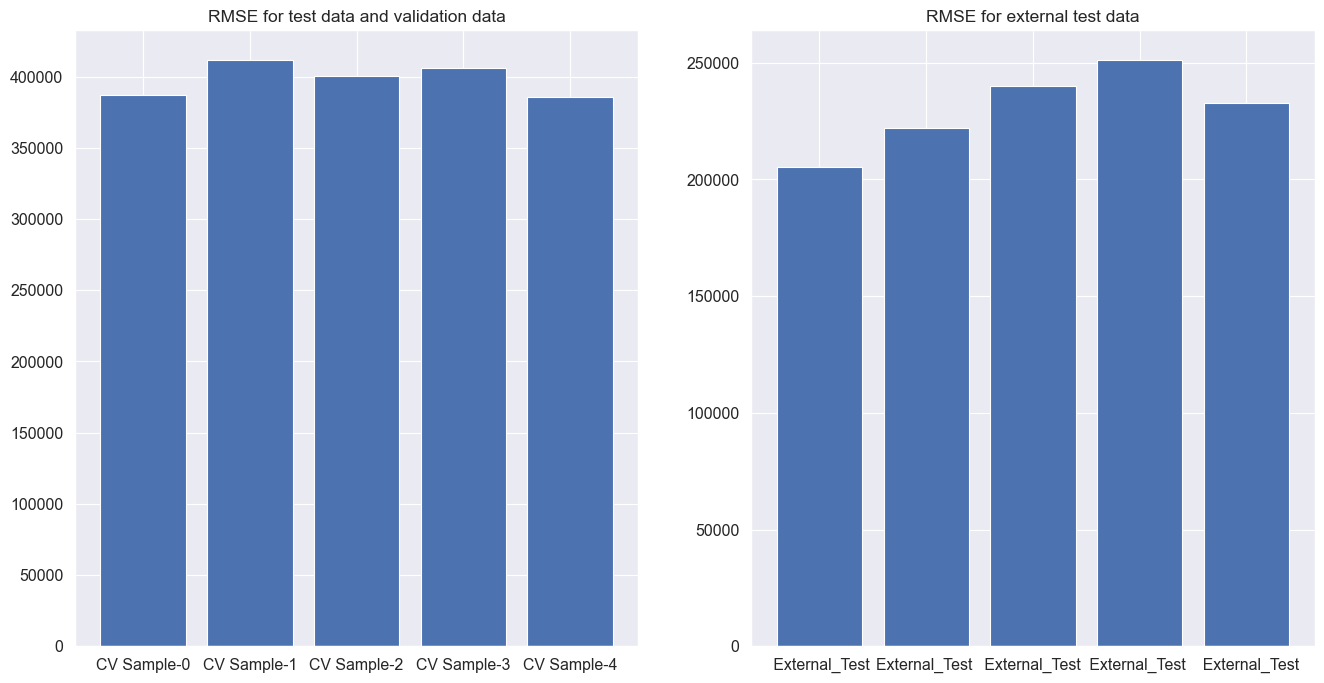

In [7]:
#initialize model
model_use = LGBMRegressor(random_state=1,n_jobs=-1,n_estimators=200)

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree,
                                                                           cutoff = 0.5,
                                                                           sequence = 'filter')

#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

Total number of input features: 124 , total number of selected features: 0
Combined cost on test and validation data is 316791.7539241518
Cost on external test data is 402028.2448307986


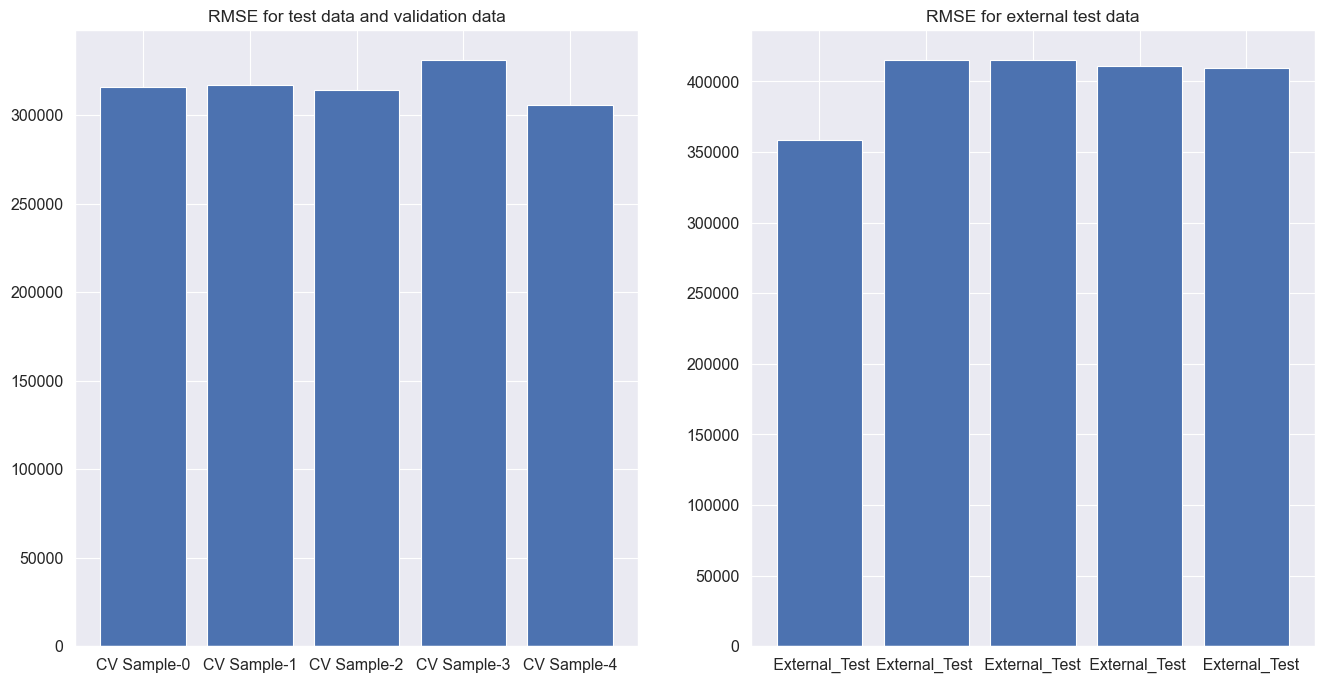

In [7]:
#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree,
                                                                           cutoff = 0.5,
                                                                           sequence = 'forward')

#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

Total number of input features: 124 , total number of selected features: 1
Combined cost on test and validation data is 348203.73468571866
Cost on external test data is 446593.8192818435


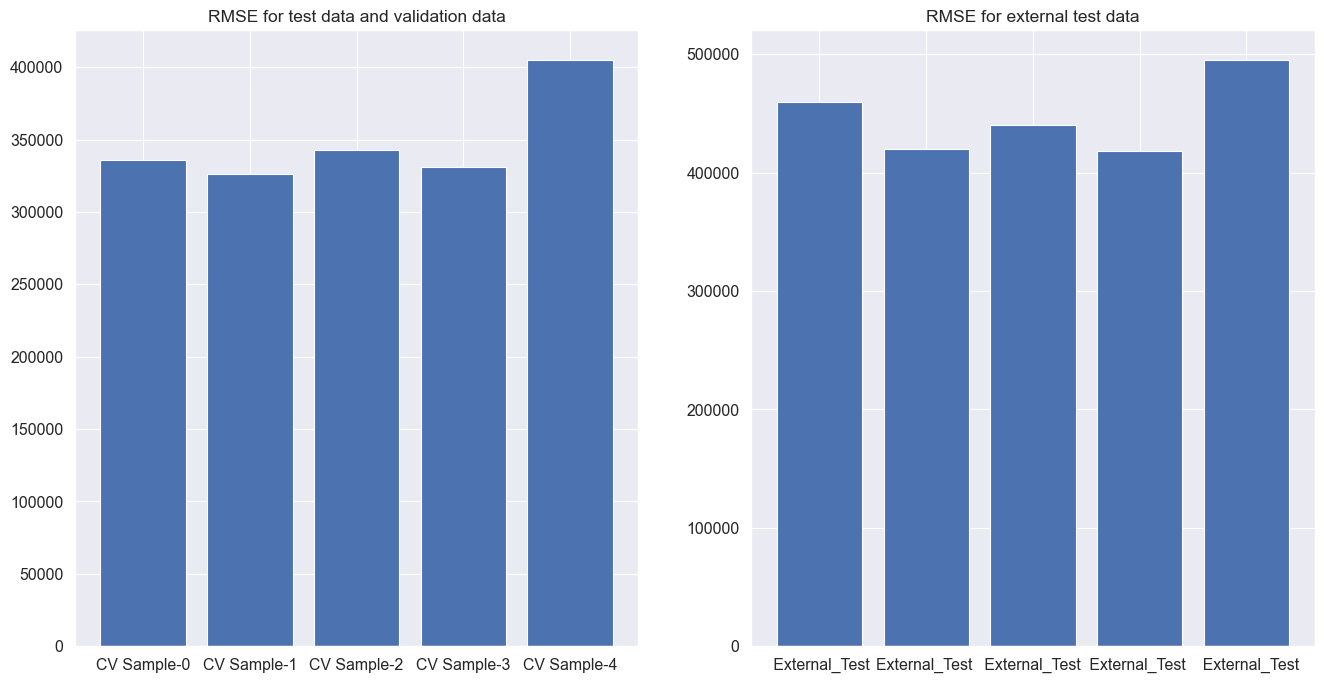

In [8]:
#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree,
                                                                           cutoff = 0.5,
                                                                           sequence = 'backward')

#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

Total number of input features: 124 , total number of selected features: 1
Combined cost on test and validation data is 348203.73468571866
Cost on external test data is 446593.8192818435


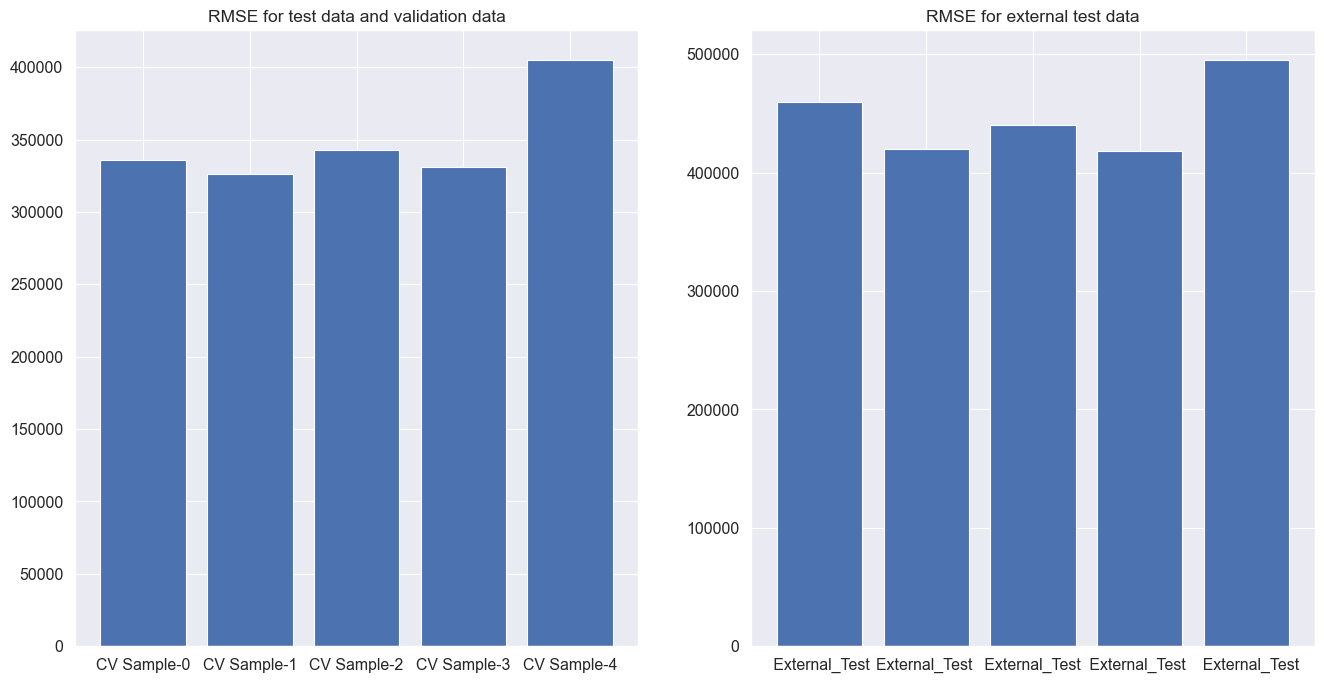

In [9]:
#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree,
                                                                           cutoff = 0.5,
                                                                           sequence = 'step')

#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

Total number of input features: 124 , total number of selected features: 6
Combined cost on test and validation data is 521168.4357531353
Cost on external test data is 282654.28401208844


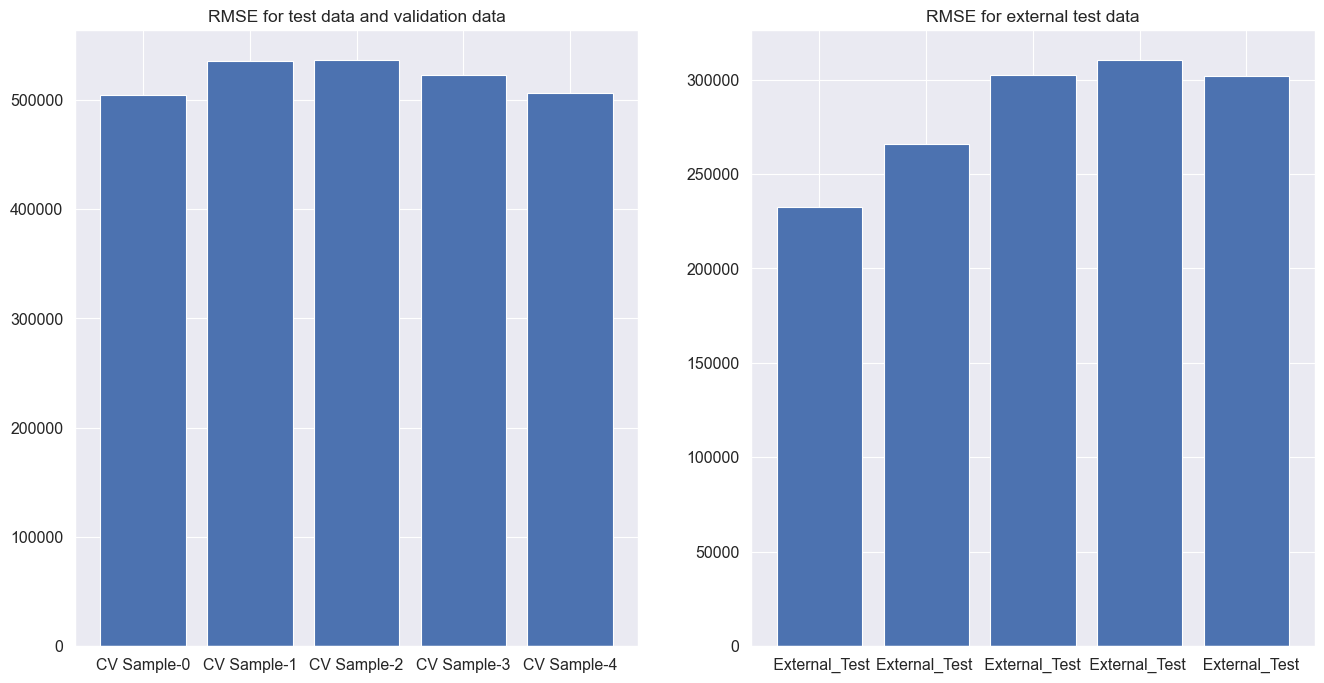

In [10]:
#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree,
                                                                           cutoff = 0.5,
                                                                           sequence = 'recursive')

#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

## Xgboost

Total number of input features: 124 , total number of selected features: 42
Combined cost on test and validation data is 415339.17034445604
Cost on external test data is 225627.7208027888


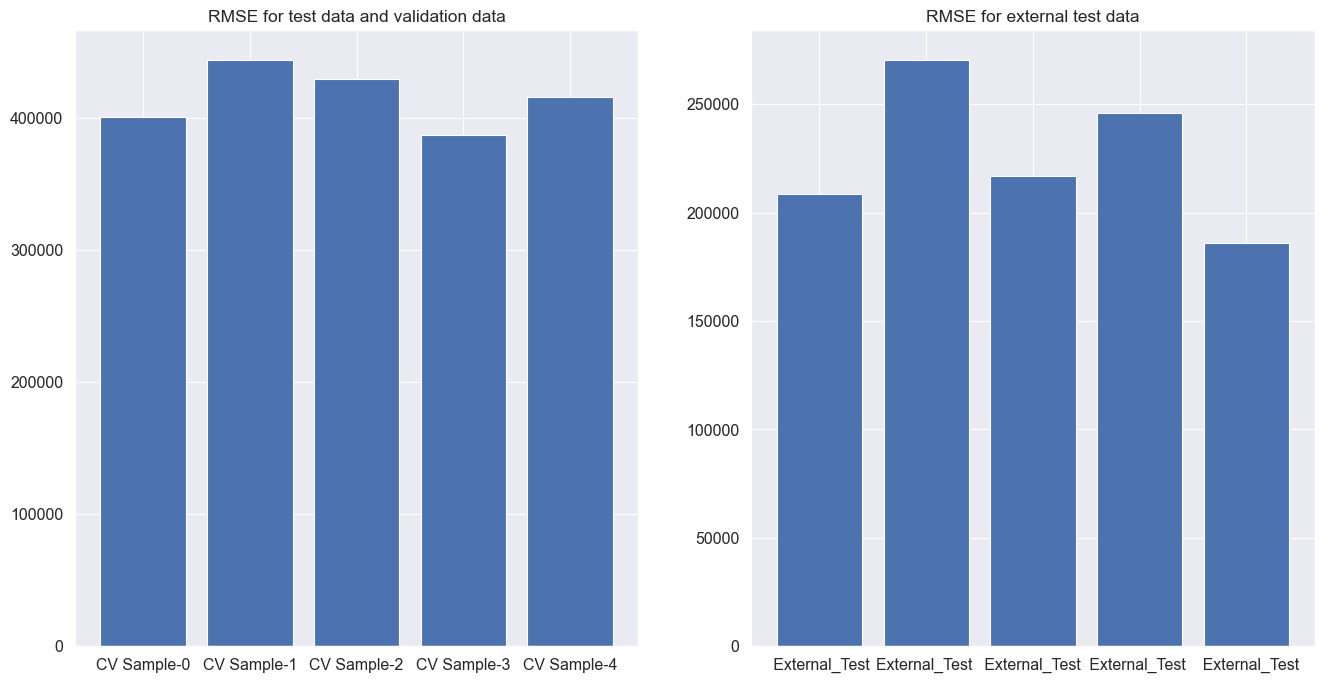

In [11]:
#initialize model
model_use = XGBRegressor(n_estimators=200,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree,
                                                                           cutoff = 0.5,
                                                                           sequence = 'filter')

#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

Total number of input features: 124 , total number of selected features: 0
Combined cost on test and validation data is 298761.3986472537
Cost on external test data is 374254.7820061209


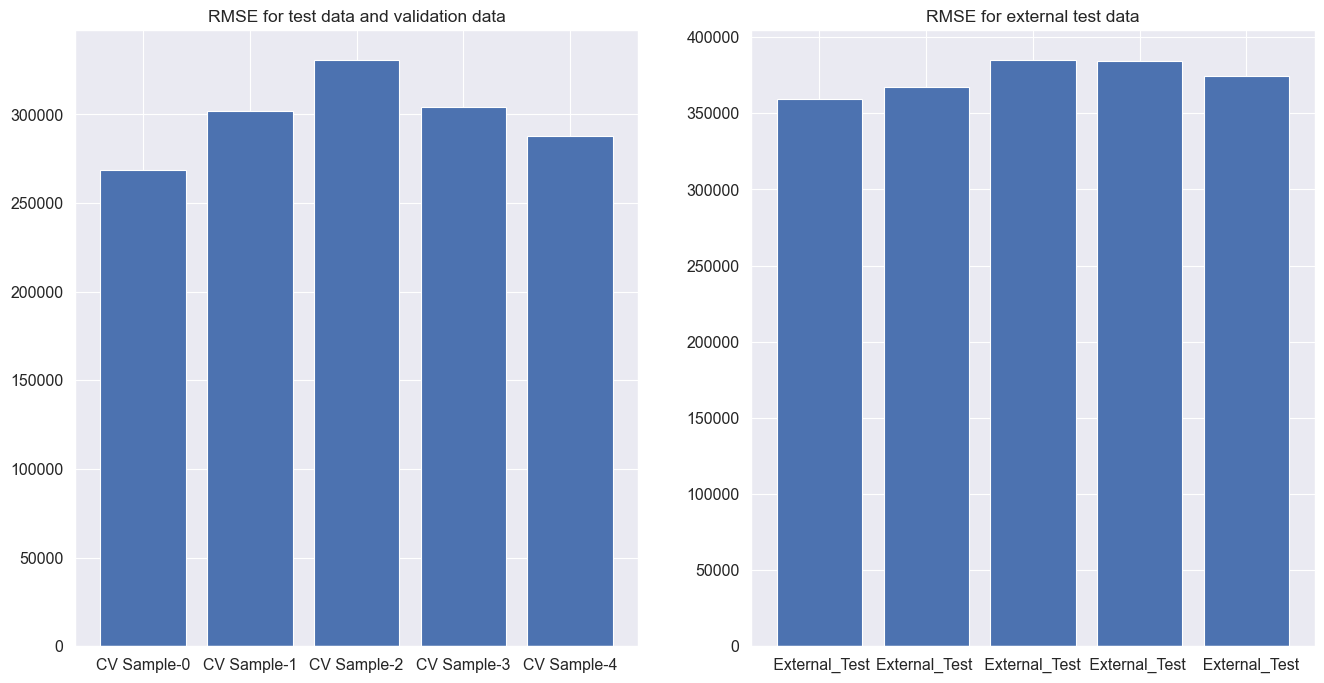

In [12]:
#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree,
                                                                           cutoff = 0.5,
                                                                           sequence = 'forward')

#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

In [ ]:
#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree,
                                                                           cutoff = 0.5,
                                                                           sequence = 'backward')

#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

In [ ]:
#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree,
                                                                           cutoff = 0.5,
                                                                           sequence = 'step')

#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

Total number of input features: 124 , total number of selected features: 5
Combined cost on test and validation data is 443267.7681393625
Cost on external test data is 269789.3740908789


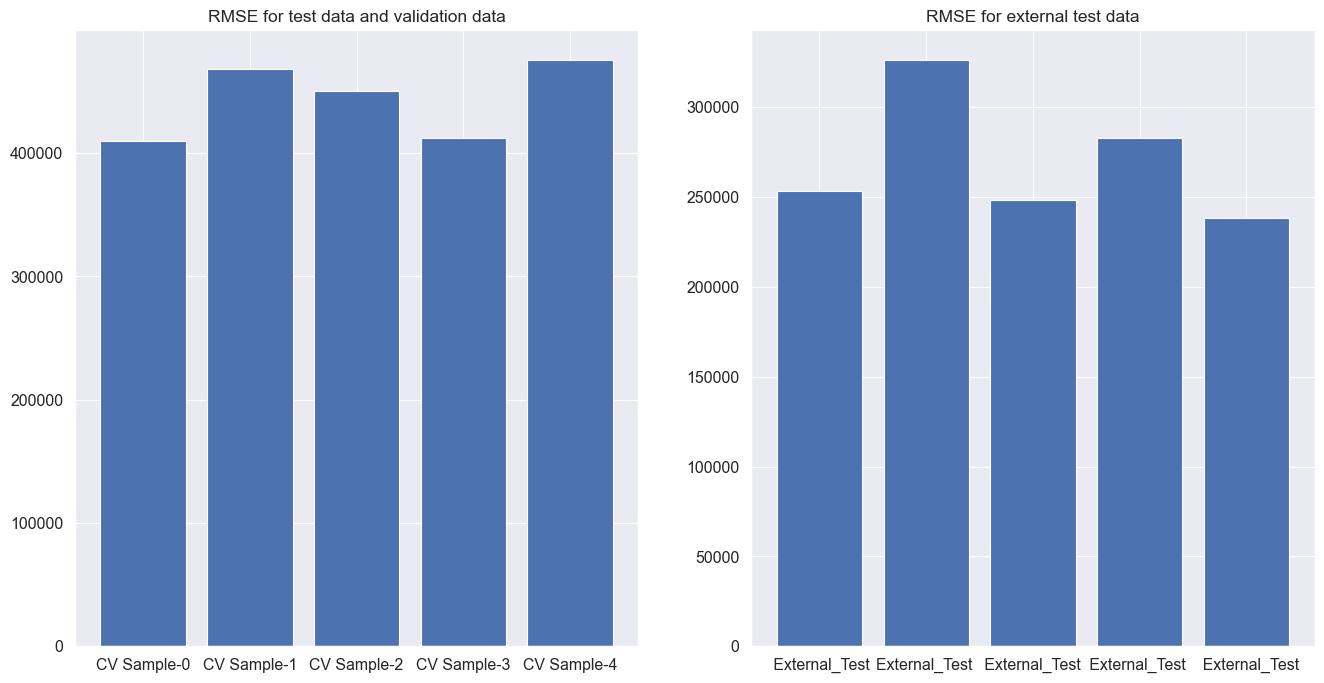

In [14]:
#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree,
                                                                           cutoff = 0.5,
                                                                           sequence = 'recursive')

#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

## Linear Regression

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Total number of input features: 4369 , total number of selected features: 596
Combined cost on test and validation data is 103646728299.10315
Cost on external test data is 113188526634.01526


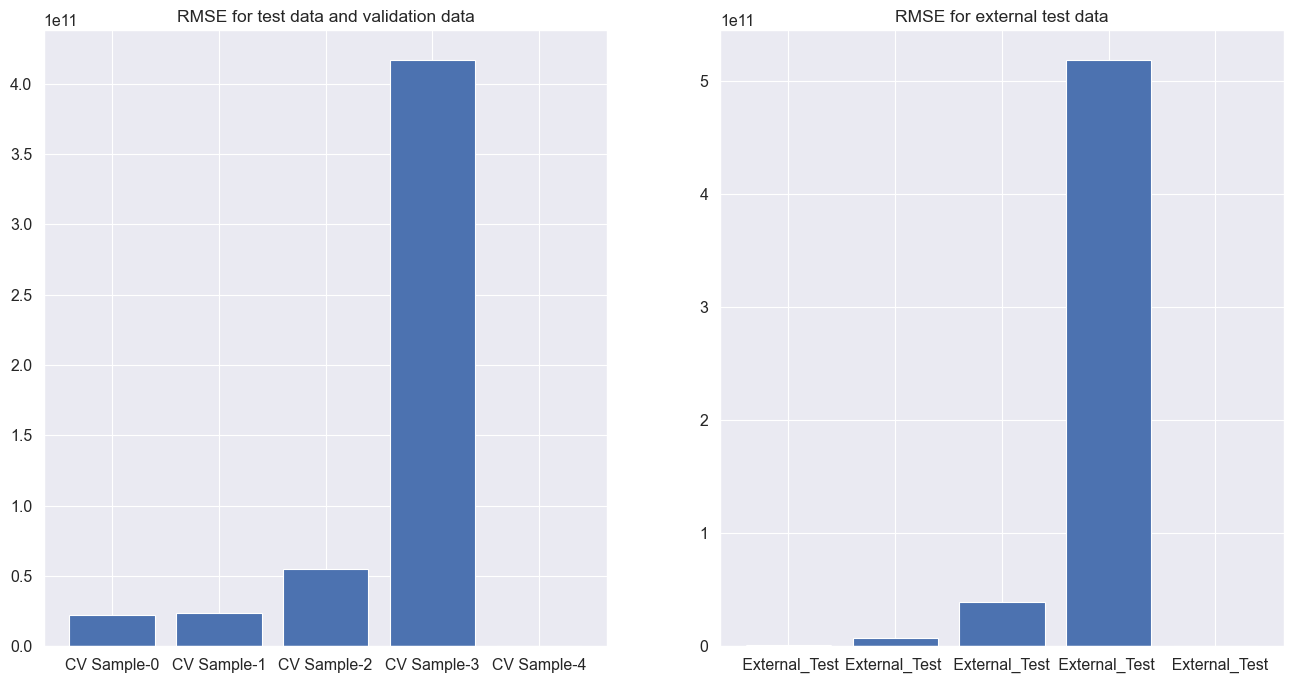

In [15]:
patch_sklearn()

#initialize model
model_use = LinearRegression(n_jobs=-1)

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = linear_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_linear,
                                                                           model = model_use,
                                                                           x_validation = x_validation_linear,
                                                                           y_validation = y_validation_linear,
                                                                           x_external = x_external_linear,
                                                                           y_external = y_external_linear,
                                                                           cutoff = 0.5,
                                                                           sequence = 'filter')

#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

Total number of input features: 4369 , total number of selected features: 0
Combined cost on test and validation data is 654857.9984719114
Cost on external test data is 577396.1717633444


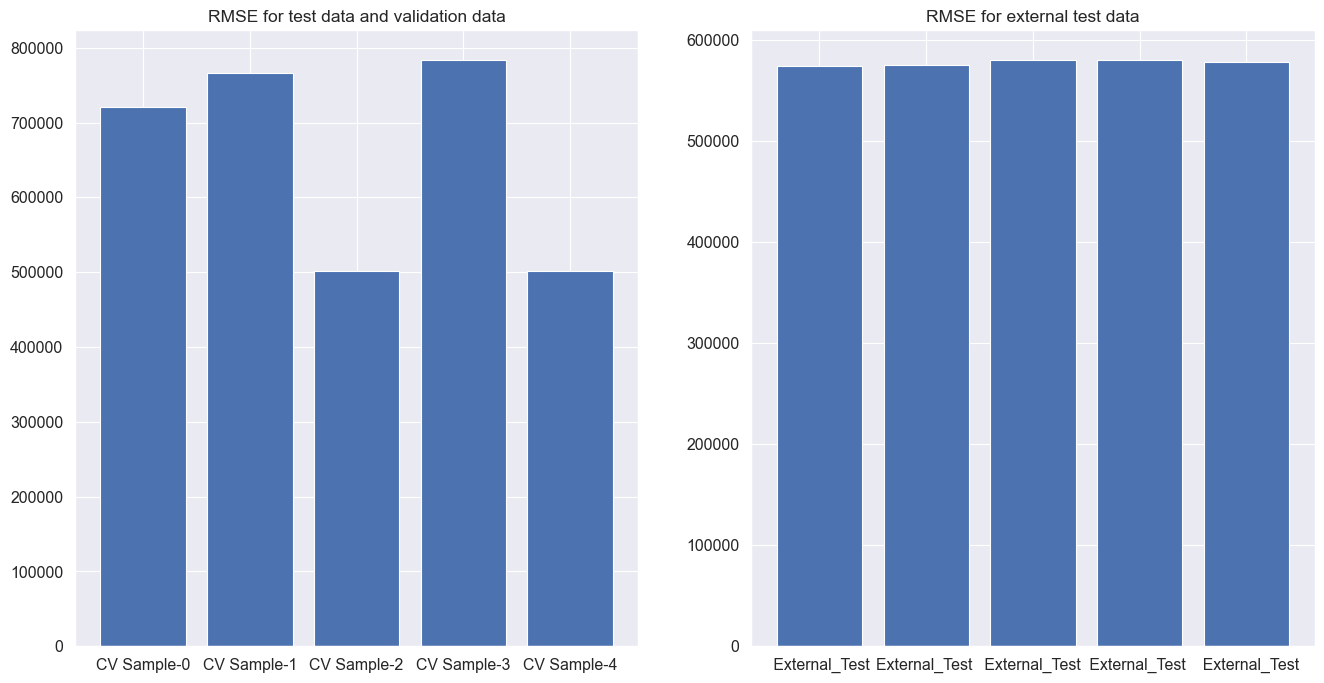

In [16]:
#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = linear_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_linear,
                                                                           model = model_use,
                                                                           x_validation = x_validation_linear,
                                                                           y_validation = y_validation_linear,
                                                                           x_external = x_external_linear,
                                                                           y_external = y_external_linear,
                                                                           cutoff = 0.5,
                                                                           sequence = 'forward')

#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

In [ ]:
#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = linear_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_linear,
                                                                           model = model_use,
                                                                           x_validation = x_validation_linear,
                                                                           y_validation = y_validation_linear,
                                                                           x_external = x_external_linear,
                                                                           y_external = y_external_linear,
                                                                           cutoff = 0.5,
                                                                           sequence = 'backward')

#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

In [ ]:
#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = linear_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_linear,
                                                                           model = model_use,
                                                                           x_validation = x_validation_linear,
                                                                           y_validation = y_validation_linear,
                                                                           x_external = x_external_linear,
                                                                           y_external = y_external_linear,
                                                                           cutoff = 0.5,
                                                                           sequence = 'step')

#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

In [ ]:
#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = linear_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_linear,
                                                                           model = model_use,
                                                                           x_validation = x_validation_linear,
                                                                           y_validation = y_validation_linear,
                                                                           x_external = x_external_linear,
                                                                           y_external = y_external_linear,
                                                                           cutoff = 0.5,
                                                                           sequence = 'recursive')

#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

In [ ]:
unpatch_sklearn()